# IRRmodel\*WCM calibration with PSO on KGE of $\sigma^0$

The v6 code is a final, cleaned and commented version.
This version, wrt to v5, implements some novelties:
- [SWB] a dynamic Kc based on a standard curve of growth of tomato crops
- [SWB] hourly ET from both Hargreaves model and FAO Penman-Monteith 
- [SWB] hourly soil moisture estimates from the soil water balance
- [WCM] hourly matching between SM estimates and sigma0 data
- [WCM] theta is substituted by the mean value of the angle of the reference orbit

In [1]:
import sys
sys.path.append('../')

from modules.funcs import *
from modules.funcs_pso import *
# from modules.pyeto import *

# KEEP YOUR MODELS IN THE NOTEBOOK UNTIL THEY ARE PERFECT
# CAUSE EXTERNAL IMPORT IS AWFUL IN JUPYTER
# from IRRI_WCM.IRRI_WCM_model import *

In [2]:
def pso_calib_irri(PAR):
    """Ausiliary function for PSO optimization"""
    global inputs
    global irri
    n_particles = PAR.shape[0]
    err = np.zeros(n_particles)
    for i in range(n_particles):
        WW,IRR,sig0,KGE = IRR_WCM(PAR[i], inputs, user_in)
        err[i] = 1 - KGE
    return err

In [3]:
def gauss(x, A, mean, dev):
    """Not-normalized, shifted gaussian distribution."""
    import math
    return A*(1/(dev*np.sqrt(2*math.pi)))*np.exp(-(x-mean)**2/(2*dev**2))

def skew_gauss(x, A, mean, dev, alpha):
    """Skew, not-normalized and shifted gaussian distribution."""

    import math
    import scipy.special as sp
    
    pdf = (1/(dev*np.sqrt(2*np.pi)))*np.exp(-pow((x-mean),2)/(2*pow(dev,2)))
    cdf = sp.erfc((-alpha*(x-mean))/(dev*np.sqrt(2)))
    return A*pdf*cdf

def hist_gauss_fit(data, nbins, hist_kwargs, fitline_kwargs,
                   title, density=False,
                   opt_save=False, dir_name='', opt_name='hist_fit',
                   func=gauss,
                  ):
    """Histogram with automatic gaussian fit.
    
    Arguments
    ---------
    - func: object, default gauss
        WARNING: skew_gauss not supported yet    
        
    """

    x = np.linspace(min(data), max(data), 200)
    counts, bins, pads = plt.hist(data, bins=nbins, density=density, **hist_kwargs)
    if func==gauss:
        fit_bounds = [ [0,min(bins),0],
                      [sum(counts)*np.diff(bins)[0],max(bins),abs(max(bins)-min(bins))] ]
    elif func==skew_gauss:
        fit_bounds = [ [0,min(bins),0],
                      [sum(counts)*np.diff(bins)[0],max(bins),abs(max(bins)-min(bins))],
                      # [-10, 10]
                     ]
    else: raise ValueError(f'Func {func} is not a valid option.')
    popt, pcov = curve_fit(func, bins[:-1], counts, method='trf',bounds=fit_bounds, maxfev=1000)
    fit = func(x, *popt)
    plt.plot(x, fit, **fitline_kwargs)
    ylabel = 'Density' if density else 'Counts'; plt.ylabel(ylabel)
    plt.legend(loc='best'); plt.title(title)
    xtext= 0.5*(plt.xlim()[1]-plt.xlim()[0])+plt.xlim()[0] # 0.8*(max(x)-min(x))+min(x);
    ytext=0.5*max(counts) #0.5*(max(counts)-min(counts))+min(counts)
    t = plt.text(xtext, ytext,
                 f'tot counts={len(data)}\nmean={popt[1]:.2f}\ndev={popt[2]:.2f} ({popt[2]/abs(popt[1])*100:.1f}%)',
                 ha="center", va="center", size=15,
                 bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))
    
    if opt_save: plt.savefig(dir_name+opt_name+'.png', dpi=300)
    
    return [counts, bins, pads, popt, pcov]

# IRRI+WCM

In [4]:
def IRR_WCM(PAR, inputs, user_in):
    """Irrigation model and WCM integration.
    
    Based on minimization of KGE between observed and simulated
    $\sigma^0$ values via PSO (pyswarm) optimization.
    The soil water balance model (IRR) produces an estimate of the soil water
    content WW [%] that is used to simulate $\sigma^0$ by a water cloud
    model (WCM).
    
    Inputs
    ----------
    - PAR: initial guess values for parameters to calibrate
        PAR = [A, B, C, D, W_0, W_max, S_fc, S_w, rho_st, Kc]
    - inputs: input quantities for calibration,
        [d, d_sat, P, IRR_obs, EPOT, WWobs, LAI, t_deg, obs]
    - user_in: user-defined options
        irri = user_in: if user_in=True, irrigation is estimated
        and not taken as an input, else the input observed irrigation
        is used in the soil water balance
    
    Return
    -------
    KGE from hydroeval between sigma0 observed and simulated.
    
    """

    # User input
    irri, units = user_in
    
    # Unpack inputs
    A, B, C, D, W_max, WW_fc, WW_w, rho_st, Kc0 = PAR
    d, d_sat, P, IRR_obs, EPOT, W_d, W_h, veg, theta, VV = inputs
    
    # Fixed parameters
    # global WW_fc  # = 0.32 # 0.32
    # global WW_w   # = 0.08 # 0.08
    # global rho_st # = 0.4 # /24 # 0.4
    # global Kc0    # = 1 # 0.05 # 1
    W_0 = W_d[0]
    
    angle  = theta*np.pi/180. # angle of incidence
    W_fc   = WW_fc*W_max # field capacity [mm]
    W_w    = WW_w*W_max # wilting point [mm]
    Ks     = [0]*len(d) # daily, water stress coefficient
    rho    = [0]*len(d) # daily, depletion fraction
    PS     = [0]*len(d) # daily, deep percolation
    W      = [0]*len(d) # daily, water content [mm]
    W[0]   = W_0*W_max # initial value of sm [mm]
    if irri==True: IRR = [0]*len(d) # daily, water content
    else: IRR = IRR_obs
    
    for t in [i+1 for i in range(len(d)-1)]:
        
        DOY=d[t].dayofyear
        
        # Build Kc curve
        # Ref. FAO56, Tables 11, 12
        START  = 134 # 14 May
        Kc_ini = 0.6*Kc0
        Kc_mid = 1.15*Kc0
        Kc_late= 0.7*Kc0

        INI =[x for x in range(START, START+30)] # initial phenological phase
        DEV =[x for x in range(START+30, START+30+40)] # development phase
        m1  =(Kc_mid-Kc_ini)/40 # daily Kc growth in DEV phase 
        MID =[x for x in range(START+30+40, START+30+40+45)] # mid phase
        LATE=[x for x in range(START+30+40+45, START+30+40+45+30)] # late stage
        m2  =(Kc_late-Kc_mid)/30 # daily Kc growth in senescence
        
        if DOY in INI: Kc=Kc_ini
        elif DOY in DEV: Kc=Kc_ini+m1*(DOY-DEV[0])
        elif DOY in MID: Kc=Kc_mid
        elif DOY in LATE: Kc=Kc_mid+m2*(DOY-LATE[0])
        elif DOY>LATE[-1]: Kc=Kc_late
        else: Kc=Kc_ini
        
        # Build Ks curve
        rho[t]=rho_st+0.04*(5-Kc*EPOT[t])
        if W[t-1]>=(1-rho[t])*W_fc:
            Ks[t]=1
        elif (W[t-1]>W_w)and(W[t-1]<(1-rho[t])*W_fc):
            Ks[t]=float(W[t-1]-W_w)/((1-rho[t])*(W_fc-W_w))
        else: Ks[t]=0
        
        # Irrigation estimate (for summer season only)
        # Irrigation is estimated as the amount of water needed from the day
        # before to take water content up to field capacity
        if irri==True:
            if np.logical_and(DOY>START,DOY<START+100): # summer season
                if W[t-1]<=(1-rho[t])*W_fc: IRR[t]=W_fc-W[t-1]
        
        # Water balance [mm]
        W[t]=W[t-1]+P[t]+IRR[t]-EPOT[t]*Kc*Ks[t]
        
        # Computation of deep percolation (water above field capacity)
        if W[t]>W_fc:
            PS[t]=W[t]-W_fc
            W[t]=W_fc
            
    WW=np.array(W)/W_max
    WWsat = pd.DataFrame(timeseries(d,WW)).set_index(0).loc[d_sat][1].values
    
    # Water Cloud Model
    sig0s_dB = C+D*WWsat # sigma0_soil [dB]
    T2 = np.exp((-2*B*veg)/np.cos(angle)) # attenuation
    sig0v = A*veg*np.cos(angle)*(1-T2) # sigma0_veg [units]
    
    if units=='lin':
        sig0s = db_lin(sig0s_dB) # sigma0_soil [lin]
        sig0_lin = T2*sig0s+sig0v # sigma0_tot [lin]
        sig0=lin_db(sig0_lin) # sigma0_tot [dB]
    elif units=='db':
        sig0 = T2*sig0s_dB+sig0v # sigma0_tot [db]
    else: raise NameError('Please choose one of the options: lin/db')
        
    OUT=he.evaluator(he.kge, sig0, VV)
    KGE=OUT[0,:];

    return [WW,IRR,sig0,KGE]

# IRRI+WCM, all params

In [5]:
def IRR_WCM_allpar(PAR, inputs, user_in):
    """Irrigation model and WCM integration.
    
    Based on minimization of KGE between observed and simulated
    $\sigma^0$ values via PSO (pyswarm) optimization.
    The soil water balance model (IRR) produces an estimate of the soil water
    content WW [%] that is used to simulate $\sigma^0$ by a water cloud
    model (WCM).
    
    Inputs
    ----------
    - PAR: initial guess values for parameters to calibrate
        PAR = [A, B, C, D, W_0, W_max, S_fc, S_w, rho_st, Kc]
    - inputs: input quantities for calibration,
        [d, d_sat, P, IRR_obs, EPOT, WWobs, LAI, t_deg, obs]
    - user_in: user-defined options
        irri = user_in: if user_in=True, irrigation is estimated
        and not taken as an input, else the input observed irrigation
        is used in the soil water balance
    
    Return
    -------
    KGE from hydroeval between sigma0 observed and simulated.
    
    """

    # User input
    irri, units = user_in
    
    # Unpack inputs
    A, B, C, D, W_max, WW_fc, WW_w, rho_st, Kc0 = PAR
    d, d_sat, P, IRR_obs, EPOT, W_d, W_h, veg, theta, VV = inputs
    
    # Fixed parameters
    W_0    = W_d[0]
    # WW_fc  = 0.35 # 0.32
    # WW_w   = 0.12 # 0.08
    # rho_st = 0.4
    # Kc0     = 1
    
    angle  = theta*np.pi/180. # angle of incidence
    W_fc   = WW_fc*W_max # field capacity [mm]
    W_w    = WW_w*W_max # wilting point [mm]
    Ks     = [0]*len(d) # daily, water stress coefficient
    rho    = [0]*len(d) # daily, depletion fraction
    PS     = [0]*len(d) # daily, deep percolation
    W      = [0]*len(d) # daily, water content [mm]
    W[0]   = W_0*W_max # initial value of sm [mm]
    if irri==True: IRR = [0]*len(d) # daily, water content
    else: IRR = IRR_obs
    
    for t in [i+1 for i in range(len(d)-1)]:
        
        DOY=d[t].dayofyear
        
        # Build Kc curve
        # Ref. FAO56, Tables 11, 12
        START  = 134
        Kc_ini = 0.6*Kc0
        Kc_mid = 1.15*Kc0
        Kc_late= 0.7*Kc0

        INI =[x for x in range(START, START+30)] # initial phenological phase
        DEV =[x for x in range(START+30, START+30+40)] # development phase
        m1  =(Kc_mid-Kc_ini)/40 # daily Kc growth in DEV phase 
        MID =[x for x in range(START+30+40, START+30+40+45)] # mid phase
        LATE=[x for x in range(START+30+40+45, START+30+40+45+30)] # late stage
        m2  =(Kc_late-Kc_mid)/30 # daily Kc growth in senescence
        
        if DOY in INI: Kc=Kc_ini
        elif DOY in DEV: Kc=Kc_ini+m1*(DOY-DEV[0])
        elif DOY in MID: Kc=Kc_mid
        elif DOY in LATE: Kc=Kc_mid+m2*(DOY-LATE[0])
        elif DOY>LATE[-1]: Kc=Kc_late
        else: Kc=Kc_ini
        
        # Build Ks curve
        rho[t]=rho_st+0.04*(5-Kc*EPOT[t])
        if W[t-1]>=(1-rho[t])*W_fc:
            Ks[t]=1
        elif (W[t-1]>W_w)and(W[t-1]<(1-rho[t])*W_fc):
            Ks[t]=float(W[t-1]-W_w)/((1-rho[t])*(W_fc-W_w))
        else: Ks[t]=0
        
        # Irrigation estimate (for summer season only)
        # Irrigation is estimated as the amount of water needed from the day
        # before to take water content up to field capacity
        if irri==True:
            if np.logical_and(DOY>START,DOY<START+100): # summer season
                if W[t-1]<=(1-rho[t])*W_fc: IRR[t]=W_fc-W[t-1]
        
        # Water balance [mm]
        W[t]=W[t-1]+P[t]+IRR[t]-EPOT[t]*Kc*Ks[t]
        
        # Computation of deep percolation (water above field capacity)
        if W[t]>W_fc:
            PS[t]=W[t]-W_fc
            W[t]=W_fc
            
    WW=np.array(W)/W_max
    WWsat = pd.DataFrame(timeseries(d,WW)).set_index(0).loc[d_sat][1].values
    
    # Water Cloud Model
    sig0s_dB = C+D*WWsat # sigma0_soil [dB]
    T2 = np.exp((-2*B*veg)/np.cos(angle)) # attenuation
    sig0v = A*veg*np.cos(angle)*(1-T2) # sigma0_veg [units]
    
    if units=='lin':
        sig0s = db_lin(sig0s_dB) # sigma0_soil [lin]
        sig0_lin = T2*sig0s+sig0v # sigma0_tot [lin]
        sig0=lin_db(sig0_lin) # sigma0_tot [dB]
    elif units=='db':
        sig0 = T2*sig0s_dB+sig0v # sigma0_tot [db]
    else: raise NameError('Please choose one of the options: lin/db')
        
    OUT=he.evaluator(he.kge, sig0, VV)
    KGE=OUT[0,:];

    return [WW,IRR,sig0,KGE]

# Data pre-processing

Input data formatting convention:
- ausiliary variables for extraction of data (directory name, file name, etc...)
- extraction into pd dataframe
- cleaning, resampling: drop unnecessary columns, set index to daily DateIndex

**Time resampling consistency**

- $\sigma^0$ values are extracted with a timestamp aaaa-mm-dd hh:mm:ss with frequency 'H' (hourly), then are rounded by `.round()` to the midnight of the nearest day to have frequency 'D' (daily), e.g. a passage at 7 am on 1st july is rounded to 0 am of 1st july, a passage at 7 pm would be rounded at 0 am of 2nd july.
- many quantities need to be resampled from hourly to daily datasets: use the `.resample()` method on a dataframe with hourly DatetimeIndex and pass the argument `origin='end_day'`. In this way, for each day X, data are considered between hours 1 and 24(=0 of day X+1) and the timestamp assigned is the one of the day X+1 (on which the operation ends). 

In [6]:
print('Starting...\n'
      +'#-------------------------------------------------------------\n'
      #+'Use of satellite-derived SM is provided for comparison, not calibration.\n'
     )
verbose = True if input("Verbose data extraction? (Describe datasets/files) [y/n]")=='y' else False

params = []; norma = ''

print('\n#-------------SWB model parameters-------------')
irri = True if input('Do you want to estimate irrigation as well as soil moisture? [y/n]')=='y' else False
year = int(input('Do you want to calibrate on year 2017 or 2020? [2017/2020]'))
freq = input('Daily or hourly frequency? [d/h]')

print('\n#-------------WCM model parameters-------------')
units = input('Calibrate WCM in linear or dB scale (determines scale of A)? [lin/db]')
opt_veg = 'NDVI'

print('\n#------------Optimization parameters-----------')
opt_calib = 'sigma0'
opt_cost = 'KGE'

PAR_str_add = input('Any addition to parameters\' names? [Type string to add]')
nrun = int(input('Number of runs? (10 is min to study distribution of parameters.) '))
n_particles = int(input('Number of particles: '))
n_step = int(input('Number of optimization steps: '))
optim = input('Global or Local PSO optimizer? [[global]/local] ')
if optim=='local': norma = 1 if input('Which norm? [l1/l2] ')=='l1' else 2
verbose_calib = True if input('Verbose during calibration? [y/n]')=='y' else False
automate = True if input('Run and save everything automatically? [y/n]')=='y' else False

Starting...
#-------------------------------------------------------------



Verbose data extraction? (Describe datasets/files) [y/n] n



#-------------SWB model parameters-------------


Do you want to estimate irrigation as well as soil moisture? [y/n] n
Do you want to calibrate on year 2017 or 2020? [2017/2020] 2017
Daily or hourly frequency? [d/h] d



#-------------WCM model parameters-------------


Calibrate WCM in linear or dB scale (determines scale of A)? [lin/db] lin



#------------Optimization parameters-----------


Any addition to parameters' names? [Type string to add] 
Number of runs? (10 is min to study distribution of parameters.)  100
Number of particles:  10
Number of optimization steps:  100
Global or Local PSO optimizer? [[global]/local]  
Verbose during calibration? [y/n] y
Run and save everything automatically? [y/n] y


## IRRmodel

Frequency: daily

Inputs:
- rain (sum, end of day)
- et0 (daily)

Comparisons:
- irrigation (sum, end of day)
- soil moisture (mean, end of day)

In [7]:
#----------------------------------------------------------------------------
# Budrio field data from platinum_df tables

# Freq: H
# Data extracted:
# - SWC (as input SWB/comparison)
# - rain (as input SWB)
# - irrigation (as input SWB)
# - temperature (as input SWB, ET0 estimate)

platinum_df = pd.ExcelFile('..\Inputs\Platinum_Budrio.xlsx', engine='openpyxl')
if year==2017: sheet='2017_1h'
if year==2020: sheet='2020_1h'
platinum_df = platinum_df.parse(sheet)
# platinum_df = pd.concat([platinum_df.parse('2017_1h'), platinum_df.parse('2020_1h')])

# Column 'Date' contains date+hour = hourly information
# Column 'Data' contains only date = daily information
platinum_df['Ora_1'] = pd.to_datetime(platinum_df['Ora'].astype('str')).apply(lambda x: x.time())
platinum_df['Data_1'] = pd.to_datetime(platinum_df['Data'].astype('str')).apply(lambda x: x.date())
platinum_df['Datetime'] = platinum_df.apply(lambda r : dtt.datetime.combine(r['Data_1'],r['Ora_1']),1)
platinum_df = platinum_df.drop(['ID', 'Data', 'Ora', 'Data_1', 'Ora_1', '214Pb[cps]'],axis=1)
platinum_df = platinum_df.set_index('Datetime')
platinum_resampled = platinum_df.resample('D', origin='end_day')
if verbose: platinum_df.info()

After long and deep thinking \
and at least ten coffee drinking \
I have reached the conclusion \
that the best possible solution \
for the inputs' database \
is in fact the easiest case: \
take each column as it is, \
resample, sum or take the mean, \
give a name to every one \
and please take it easy for once!

In [8]:
# Build inputs as timeseries (using the nominal function)
# timeseries(dates, data) -> matrix[columns={dates, data}]

In [9]:
from IRRI_WCM.EPOT_Hargreaves_pyeto import *

lat_deg = 44.570842547510622 # latitude of Budrio (deg)
temp_min = platinum_resampled.min()['Temperatura[°C]'].values
temp_max = platinum_resampled.max()['Temperatura[°C]'].values
temp_mean = platinum_resampled.mean()['Temperatura[°C]'].values
dates = platinum_resampled.asfreq().index
eto = timeseries( dates,
                 [ hargre(lat_deg, dates[i] , temp_min[i], temp_max[i], temp_mean[i])
                  for i in range(len(dates)) ] )
eto_df = pd.DataFrame(eto).rename(columns={0:'Date',1:'EPOT'}).set_index('Date')
if verbose: eto_df.info()

## WCM

Frequency: multi-daily

Inputs:
- $\sigma^0$, $\theta$ (hourly, rounded to nearest midnight)
- vegetation descriptors (NDVI, LAI, CR) (average, daily)

In [10]:
#----------------------------------------------------------------------------
# Sigma0 values

# Freq: D
# Daily values of backscattering from 2014 to 2022 (complete S1 series)
# Data extracted:
# - sigma0 values, VV and VH
# - angle of incidence of reference orbit (nearest to 40°)

sigma_df = pd.read_csv('..\Data\\budrio-half.csv', delimiter='\t');
sigma_df['Datetime'] = sigma_df.Date.apply(lambda x : pd.to_datetime(x))
sigma_df.Date = sigma_df.Date.apply(lambda x : pd.to_datetime(x).round(freq='D'))
sigma_df = sigma_df.set_index('Date')
if verbose: sigma_df.info()

In [11]:
sigma_df.loc[sigma_df.Orb==95]['Angle[°]'].mean()

41.278799295425415

In [12]:
sigma_df['Angle[°]'] = sigma_df['Angle[°]'].apply(lambda x : 41.278799295425415)

In [13]:
#----------------------------------------------------------------------------
# NDVI values

# Freq: D
# Daily values of NDVI from 2017-4-24 to 2023-1-13 (complete S2 series)
# Data extracted:
# - NDVI (daily, interpolated)

ndvi_df = pd.read_csv('..\Data\\budrio-half_NDVI.csv', delimiter='\t');
ndvi_df.Date = ndvi_df.Date.apply(lambda x : pd.to_datetime(x))
ndvi_df = ndvi_df.set_index('Date')
if verbose: ndvi_df.info()

# Input data

In [14]:
# Input SWB
# Frequency: daily
# Data:
# - rain (sum, end of day) from platinum_resampled
# - eto (daily) from eto_df

if freq=='d':
    input_swb = pd.merge(right=eto_df, left=platinum_resampled.sum(),
                     right_on='Date', left_on='Datetime', right_index=True)\
                    .drop(['SWC[m3/m3]','Temperatura[°C]'], axis=1)
    input_swb['SWC[m3/m3]'] = platinum_resampled.mean()['SWC[m3/m3]']
    if verbose: input_swb.info()

# Input SWB
# Frequency: hourly
# Data:
# - rain (hourly) from platinum_df, linear interpolation
# - irrigation (hourly) from platinum_df
# - eto (daily) from eto_df, up-resampled hourly with linear interpolation

elif freq=='h':
    eto_df_h = eto_df.resample('H').asfreq().interpolate(method='linear')
    input_swb = pd.merge(right=eto_df_h, left=platinum_df,
                         right_on='Date', left_on='Datetime', right_index=True)\
                        .drop(['Temperatura[°C]'], axis=1)
    input_swb['Pioggia[mm]'].interpolate(method='linear',inplace=True)
    if verbose: input_swb.info()

Let me make another coffee \
as I'd like to tell you a story: \
there was a warrior once \
that rode a python through the lands \
and everywhere she went \
her model could converge \
until an error rose from the hourly database \
ruby red, spitting fire, with three heads: \
all the particles were lost, with no \
position, velocity, energy or goal. \
But then the sky was opened by a shear of light: \
"Beware, my dear," - a deep voice rumbled - \
"of nans: your guard shoul always be up \
against missing input values! \
And don't you dare dropna: \
linearly interpolate, as you must!"

---
**ChatGPT upgrade in ironic, old-english style**

Verily, 'tis a tale most curious, \
Of a warrior bold and fierce, \
Who rode upon a serpent thus, \
And traversed the lands without a peer. 
 
But lo, a glitch did arise, \
In her model's calculations grand, \
A ruby-red error did surprise, \
With three heads, spitting fire like a dragon. 
 
All particles were lost, astray, \
With nary a position or a goal, \
The sky did open in a blaze, \
And a voice, deep and ominous, did toll: 
 
"Beware, O warrior fair, \
Of nans, for they are most vile, \
Let thy guard ever be aware, \
Against missing input values all the while." 
 
And so the warrior did learn, \
To keep a watchful eye, \
And with her python did return, \
To conquer all the lands, high and dry. 
 
Pray, heed the lesson well, \
For nans are ever present, \
And a vigilant guard, doth tell, \
Of victory, most evident. 

In [15]:
# Input WCM
# Frequency: daily
# Data:
# - sigma0 (multi-daily, rounded at nearest midnight)
# - NDVI (daily, interpolated)
# Merging is performed without any time offset, considering that the change
# in ndvi values anywhere is very small from one day to another 

input_wcm_sat = pd.merge(right=sigma_df, left=ndvi_df, on='Date', how='right')
input_wcm_sat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1150 entries, 2014-10-12 to 2022-11-28
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   NDVI         916 non-null    float64       
 1   Geometry_x   916 non-null    object        
 2   Angle[°]     1150 non-null   float64       
 3   Geometry_y   1150 non-null   object        
 4   Orb          1150 non-null   int64         
 5   Pass         1150 non-null   object        
 6   VV_norm[dB]  1150 non-null   float64       
 7   VH_norm[dB]  1150 non-null   float64       
 8   CR           1150 non-null   float64       
 9   Datetime     1150 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 98.8+ KB


In [16]:
input_wcm = pd.merge(right=input_wcm_sat, left=platinum_df, on='Datetime',
                     how='inner')\
            .drop(['Pioggia[mm]','Irrigazione[mm]','Temperatura[°C]',
                   'Geometry_x'], axis=1)\
            .rename(columns={'SWC[m3/m3]':'SWC_h', 'Geometry_y':'Geometry',
                             'VV_norm[dB]':'VV', 'VH_norm[dB]':'VH', 'Angle[°]':'Angle'})

#----------------------------------------------------------------------------
# Convenience method for printing labels of columns that are interpolated
# only on the basis of their length being less than the length of the df,
# and not taking into consideration if they are being interpolated or extr

# print('The following columns will be interpolated: '
#       +f'{[x for x in input_wcm if len(input_wcm[x].dropna())<len(input_wcm)]}\n')
# if input('Proceed? [y/n]')!='y':
#      raise NameError('Stop and stare! I think I\'m going but I don\'t know where!')
#----------------------------------------------------------------------------

print(
    '\nNDVI values are limited below at the 24 of april 2017, so they are'+
    'backward propagated for 30 days in order to cover the whole Budrio period.'+
    ' There is a gap in SWC values: this gap is not interpolated but is used to'+
    'eliminate those days with nan SM values from the days of passage of the'+
    'satellite.\n'
)
input_wcm.NDVI.interpolate(method='bfill',
                           limit_direction='backward',
                           limit=30,
                           # limit_area='inside', # THIS WORKS VERY BADLY IN EVERY WAY
                           inplace=True)
if freq=='d': input_wcm.index = input_wcm.Datetime.round('D')
elif freq=='h': input_wcm.index = input_wcm.Datetime
input_wcm.dropna(inplace=True)
if verbose: input_wcm.info()


NDVI values are limited below at the 24 of april 2017, so they arebackward propagated for 30 days in order to cover the whole Budrio period. There is a gap in SWC values: this gap is not interpolated but is used toeliminate those days with nan SM values from the days of passage of thesatellite.



In [17]:
# List of 2017 and 2020 dates

# Complete days in 2017, 2020
t = [x for x in input_swb.index if x.year==year]
     
# Days of passage of satellite, intersect with complete days
set1 = {x for x in input_swb.index}; set2 = {x for x in input_wcm.index};
intersect = np.sort(np.array([*set1.intersection(set2)]))
t_sat = [x for x in intersect if x.year==year]

In [18]:
P       = input_swb.loc[t]['Pioggia[mm]'] # [mm]
IRR_obs = input_swb.loc[t]['Irrigazione[mm]'] # [mm]
EPOT    = input_swb.loc[t]['EPOT'] # [mm/day]
WW_obs  = input_swb.loc[t]['SWC[m3/m3]'] # daily mean or hourly, with gaps
WW_sat  = input_wcm.loc[t_sat]['SWC_h'] # punctual at hour (observed) [m3/m3]
veg     = input_wcm.loc[t_sat]['NDVI'] # [-]
theta   = input_wcm.loc[t_sat]['Angle'] # [°]
VV      = input_wcm.loc[t_sat]['VV'] # [dB]
VH      = input_wcm.loc[t_sat]['VH'] # [dB]
CR      = input_wcm.loc[t_sat]['CR'] # [-]

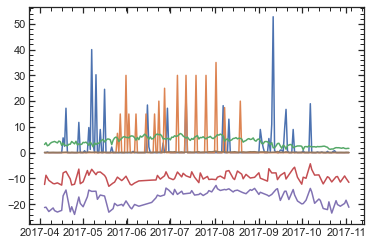

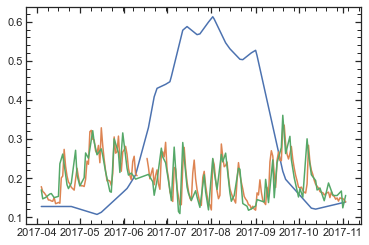

In [19]:
for x in [P,IRR_obs,EPOT,VV,VH,CR]: plt.plot(x)
plt.show()
for x in [veg,WW_obs,WW_sat]: plt.plot(x)

# Calibration SWB+WCM

In [20]:
# Calibration SWB+WCM

print('Starting calibration...\n'+
      '#-------------------------------------------------------------\n')
start = time.time()

A=0.3; B=1.5; C=-15; D=30 # guess params for WCM
W_max=    10;   # [mm] water content, maximum (not normalized)
WW_fc=    0.32; # [m3/m3] water content at field capacity
WW_w=     0.08; # [m3/m3] water content at wilting point
rho_st=   0.4;  # [-] crop specific depletion fraction
Kc0=      1;  # [-] crop specific coefficient
if freq=='h': rho_st/=24; Kc0/=24

# PAR string of names
PAR_str = ['A', 'B', 'C', 'D', 'W_max', 'WW_fc', 'WW_w', 'rho_st', 'Kc0']
if units=='db': PAR_str = [el + '_db' for el in PAR_str]
# if not PAR_str_add=='': PAR_str = [el+PAR_str_add for el in PAR_str]

PAR     = [A, B, C, D, W_max, WW_fc, WW_w, rho_st, Kc0]
PARn_str= ['A', 'B', 'C', 'D', 'W_max', 'WW_fc', 'WW_w', 'rho_st', 'Kc0']
inputs  = [t, t_sat, P, IRR_obs, EPOT, WW_obs, WW_sat, veg, theta, VV]
user_in = [irri, units]

if units=='lin':
    bounds = (
        np.array([0.1, 0.1, -20, 10,   1, 0.3, 0.08, 0.01, 0.001]), # low
        np.array([1,   3,   -10, 50, 150, 0.4, 0.15, 0.8,  1.5]), # up
    )
elif units=='db':
    bounds = (
        np.array([ -20, 0.1, -20, 10,   1, 0.3, 0.08, 0.01, 0.001]), # low
        np.array([ -10, 3,   -10, 50, 150, 0.4, 0.15, 0.8,  1.5]), # up
    )
else: raise NameError(f'Scale can only be lin or db but {scale} was provided.')

#-----------------------------------------------------------------------------
from pyswarms.backend.handlers import OptionsHandler

params = []
for i in range(int(nrun)):
    if (optim=='global')or(optim==''):
        optim='global'
        # options = {'c1': 0.5, 'c2': 0.9, 'w': 0.6}
        options = {'c1': 2.05, 'c2': 2.05, 'w': 0.6}
        oh_strategy = {"w":'exp_decay', 'c1':'lin_variation', 'c2':'lin_variation'}
        optimizer = ps.single.GlobalBestPSO(n_particles=int(n_particles),
                                            dimensions=len(PAR),
                                            options=options,
                                            bounds=bounds,
                                            oh_strategy=oh_strategy,
                                           )
    elif optim=='local':
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8, 'k':int(0.1*n_particles), 'p':norma }
        optimizer = ps.single.LocalBestPSO(n_particles=n_particles,
                                           dimensions=len(PAR),
                                           options=options,
                                           bounds=bounds,
                                           oh_strategy={"w":'exp_decay',
                                                         'c1':'lin_variation',
                                                         'c2':'lin_variation'})
    else: raise NameError('Please provide an accepted option.')
    
    cost, PARn = optimizer.optimize(pso_calib_irri, n_step, verbose=verbose_calib)#, **PAR)
    params.append(PARn)

end = time.time()

2023-02-02 08:17:48,674 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Starting calibration...
#-------------------------------------------------------------



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|100/100, best_cost=0.382
2023-02-02 08:18:05,609 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3818248627267886, best pos: [  0.34955776   0.79751203 -13.92763944  23.85455323  18.51314731
   0.36022126   0.11460899   0.18388303   0.70489021]
2023-02-02 08:18:05,633 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}
pyswarms.single.global_best:  13%|███████▉                                                     |13/100, best_cost=0.471


KeyboardInterrupt: 

In [21]:
params

[array([  0.34955776,   0.79751203, -13.92763944,  23.85455323,
         18.51314731,   0.36022126,   0.11460899,   0.18388303,
          0.70489021])]

In [ ]:
print('Timing: ', round((end-start)/60/nrun, 2), ' min for 1 run,', round((end-start)/60, 2), 'min total')

In [23]:
len(params)

1

# Parameters' study

In [25]:
timestr = time.strftime("%y%m%d-%H%M%S"); print('Timestring: ', timestr)

Timestring:  230202-081958


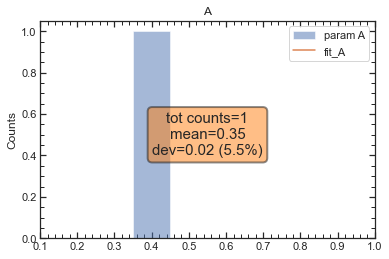

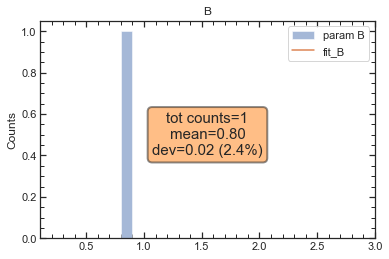

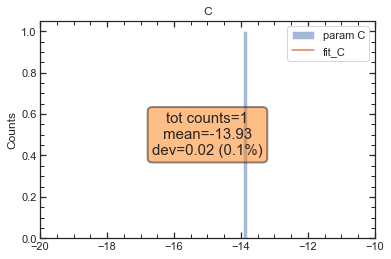

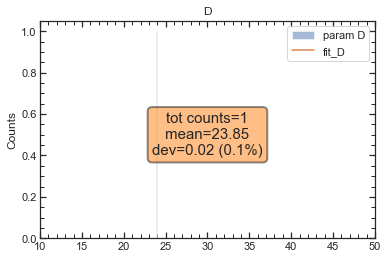

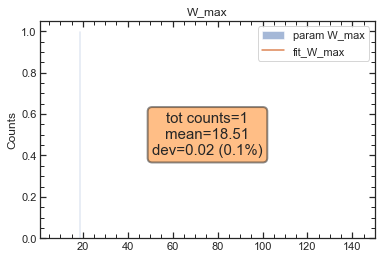

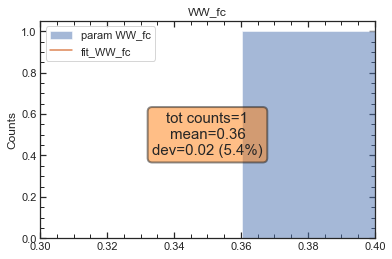

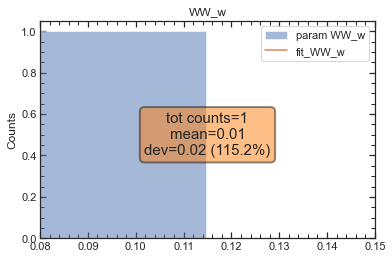

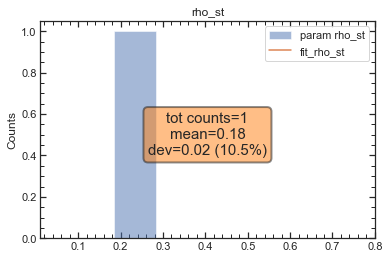

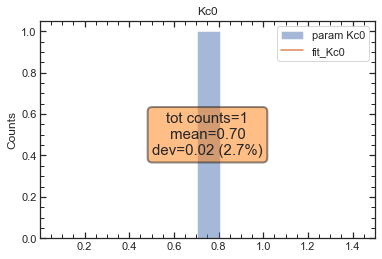

{'A': [0.3, 'cal', [0.1, 1.0], 0.35, 0.019],
 'B': [1.5, 'cal', [0.1, 3.0], 0.798, 0.019],
 'C': [-15, 'cal', [-20.0, -10.0], -13.928, 0.019],
 'D': [30, 'cal', [10.0, 50.0], 23.855, 0.019],
 'W_max': [10, 'cal', [1.0, 150.0], 18.513, 0.019],
 'WW_fc': [0.32, 'cal', [0.3, 0.4], 0.36, 0.019],
 'WW_w': [0.08, 'cal', [0.08, 0.15], 0.015, 0.017],
 'rho_st': [0.4, 'cal', [0.01, 0.8], 0.184, 0.019],
 'Kc0': [1, 'cal', [0.001, 1.5], 0.705, 0.019]}

In [26]:
matrix = np.array(
    [
        np.array(
            [ params[i][j] for i in range(len(params)) ])
        for j in range(len(PAR))
    ]
)

PAR_dict = {
    'A':     [round(A, 2) ],
    'B':     [round(B, 2) ],
    'C':     [round(C, 2) ],
    'D':     [round(D, 2) ],
    'W_max': [round(W_max, 2) ],
    'WW_fc': [round(WW_fc, 2) ],
    'WW_w':  [round(WW_w, 2) ],
    'rho_st':[round(rho_st, 2) ],
    'Kc0' :  [round(Kc0, 2)]
}

PARn = []
PARn_dev = []

if automate: opt_save=True
else: opt_save = True if input('Save histograms of params? [y/n]')=='y' else False

for label in PAR_dict:
    if label in PARn_str:
        i = PARn_str.index(label)
        
        if nrun==1:
            PARn=[x[0] for x in matrix]
            PARn_dev=[0 for x in matrix]
        else:
            hist_kwargs={'alpha':.5, 'label':f'param {label}'}
            fitline_kwargs={'linestyle':'-', 'label':f'fit_{label}'}
            data = matrix[i]
            nbins = 10 if nrun<100 else np.sqrt(nrun)-4
            plt.xlim(bounds[0][i], bounds[1][i]);
            counts, bins, pads, popt, pcov = hist_gauss_fit(
                data, nbins=10, hist_kwargs=hist_kwargs, fitline_kwargs=fitline_kwargs,
                title=f'{label}', density=False,
                opt_save=opt_save, dir_name='Plot\\', opt_name=f'{timestr}_hist_{label}',
                func=gauss)
            PARn.append(popt[1])
            PARn_dev.append(popt[2])    
            plt.show()
        
        PAR_dict[label].append('cal')
        PAR_dict[label].append([bounds[0][i], bounds[1][i]])
        PAR_dict[label].append(np.round(PARn[i], 3))
        PAR_dict[label].append(np.round(PARn_dev[i], 3))
    else:
        PAR_dict[label].append('fix')
        PAR_dict[label].append(['/', '/'])
        PAR_dict[label].append(PAR_dict[label][0])
        PAR_dict[label].append('/')

PAR_dict

# Model output - plots sim VS obs for SM, sigma0

In [ ]:
# Model validation and output

if not automate:
    if input('Do you want to plot with user-defined parameters\' values ? [y/n]')=='y':

        # PAR  = [A, B, C, D, W_max, Kc]
        # PARn = [0.29, 3.36, -15.75, 40.92, 100.18, 0.58] # [lin]
        # PARn = [-15, 0.49, -21.06, 33.77, 100.18, 0.44] # [db] # NEED TO RUN AGAIN IF UNITS CHANGE
        # PARn = [0.29,2.14,-14.69,35.79,100,0.72] # [lin] new params Kc
        # PARn = [0.28, 0.71, -12.88, 22.78, 16.56, 0.50] # [lin] Wmax in [1,150]
        # PARn = [0.3179471,1.75074996,-18.0340179,41.18898174,100.05601716]
        # WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, user_in)
        
        # # Model version with all params
        # PARn = [0.3, 1.4, -15, 40, 100, 0.32, 0.08, 0.4/24, 0.05]
        
        timestr = time.strftime("%y%m%d-%H%M%S"); print('Timestring: ', timestr)
        
        # PARn = [0.3, 3, -5, 40, 100, 0.32, 0.08, 0.4/24, 1/24]
        # PAR_tot = [PAR_dict[label][3] for label in PAR_dict]
        PAR_tot = [0.357, 0.808, -16.258, 32.728, 4.136, 0.339, 0.088, 0.072, 0.005]
        timestr = '230131-165510'
        print(PAR_tot)
        WW,IRR,sigma0,KGE = IRR_WCM_allpar(PAR_tot, inputs, user_in)
    else: WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, user_in)

else: WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, user_in)

In [ ]:
if automate: opt_save_table = True
else: opt_save_table = True if input('Save table with machine params? [y/n]')=='y' else False

fig, ax = plt.subplots(figsize=(14,5))
row_height=0.1; col_width=0.7

# Table with machine, inputs params
timing = 'daily' if freq=='d' else 'hourly'
cellText = [
    ['Units', units],
    # ['Cost function', opt_cost],
    # ['Calib on', opt_calib],
    ['Optimizer:', optim],
    ['Optimizer: options', options],
    ['Optimizer: strategy', oh_strategy],
    ['N runs, particles, optim. steps', str(nrun)+', '+str(n_particles)+', '+str(n_step)],
    ['Time frequency', timing],
    ['Vegetation descriptor', opt_veg],
]
table = ax.table(cellText=cellText,
                     cellLoc='center', loc='center',
                     colLabels=None, rowLabels=None)

for (row, col), cell in table.get_celld().items():
    cell.set_height(row_height)
    cell._loc = 'center'

table.auto_set_font_size(False); table.set_fontsize(20)
table.auto_set_column_width(col=[x for x in range(len(PAR_dict))])
ax.axis('tight'); ax.axis('off')

if opt_save_table: plt.savefig(f'Plot\\{timestr}_table_mach.png', dpi=100)
plt.show()

In [ ]:
if automate: opt_save_table = True
else: opt_save_table = True if input('Save table with params? [y/n]')=='y' else False

fig, ax = plt.subplots(figsize=(24,5))
row_height=0.1; col_width=0.1

# Table with params
cellText = [[PAR_dict[label][i] for label in PAR_dict] for i in range(5)]
colLabels = [x for x in PAR_dict]
rowLabels = ['Guess/fix value', 'Cal/fix', 'Bounds', 'Mean', 'St.dev.']

#---------------------------------
table = ax.table(cellText=cellText,
                  cellLoc='center', loc='center',
                  colLabels=colLabels,
                  rowLabels=rowLabels,
                )

for (row, col), cell in table.get_celld().items():
    if row == 0: # or col == 0:
        cell.set_text_props(weight='bold')
    cell.set_height(row_height)
    cell._loc = 'center'

table.auto_set_font_size(False); table.set_fontsize(20)
table.auto_set_column_width(col=[x for x in range(len(PAR_dict))])
ax.axis('tight'); ax.axis('off')

if opt_save_table: plt.savefig(f'Plot\\{timestr}_table.png')
plt.show()

## Triple plot SM+$\sigma^0$+inputs

In [ ]:
if automate: opt_save = True
else: opt_save = True if input('Save triple plot SM+s0+inputs? [y/n]')=='y' else False

fig, ax = plt.subplots(3, 1,constrained_layout=False,figsize=(16, 9), sharex=True,dpi=300,)
filename = f'triple_'+units+'_'+PAR_str_add

#----------------------------------------------------------------------------
# Box with params

PAR_text='Parameters\n'

try:
    for i in range(len(PAR_str)): PAR_text+=f'    {PAR_str[i]} = {PAR_tot[i]}'
except NameError:
    for label in PAR_dict: PAR_text+=f'    {label} = {PAR_dict[label][3]}'

fig.text(0.5, 0.95,
         PAR_text, ha='center', va='center',
         bbox={'facecolor':'white', 'edgecolor':'black'},
         transform=fig.transFigure,
         fontsize='large',
        )

#----------------------------------------------------------------------------
# Plot of sigma0

obs = VV; obs_label=r'$\sigma^0_{obs}$'
sim = sigma0; sim_label=r'$\sigma^0_{sim}$'
labely = r'$\sigma^0$[dB]'
times = t_sat
marker='o'; linestyle='-'

RMSE=np.mean((sim-obs)**2)**0.5; print('RMSE =', RMSE)
R=np.corrcoef(sim,obs)[0][1]; print('R=', R)
BIAS=bias(sim,obs); print('bias =', BIAS)
print('KGE=', KGE[0])

title=f'{sim_label} VS {obs_label} - RMSE={RMSE:.2f}, R={R:.2f}, bias={BIAS:.2f}, KGE={KGE[0]:.2f}'

ax[0].set_xlim(xmin=times[0], xmax=times[len(times)-1])
ax[0].plot(times, sim, c='tab:red', label=sim_label,
           linestyle=linestyle, marker=marker, )#alpha=.4, zorder=-1)
ax[0].plot(times, obs, c='tab:blue', label=obs_label,
           linestyle=linestyle, marker=marker, alpha=.4, zorder=-1)
ax[0].legend(loc='upper left')
ax[0].set_title(title)
ax[0].set_ylabel(labely)

ax1 = ax[0].twinx()
ax1.plot(times, veg, label=opt_veg, color='tab:green')
ax1.legend(loc='upper right')
ax1.set_ylabel(opt_veg)
#----------------------------------------------------------------------------
# Plot of SM

obs = WW_obs; obs_label='SM_obs'
sim = WW; sim_label='SM_sim'
times = t

# RMSE, NS, R, bias calculation
RMSE=np.nanmean((sim-obs)**2)**0.5; print('RMSE =', RMSE)
NS=1-np.nansum((sim-obs)**2)/np.nansum((obs-np.nanmean(obs))**2); print('NS =', NS)
NS_radQ=1-np.nansum((np.sqrt(sim+0.00001)-np.sqrt(obs+0.00001))**2)/np.nansum((np.sqrt(obs+0.00001)-np.nanmean(np.sqrt(obs+0.00001)))**2)
NS_lnQ=1-np.nansum((np.log(sim+0.0001)-np.log(obs+0.0001))**2)/np.nansum((np.log(obs+0.0001)-np.nanmean(np.log(obs+0.0001)))**2)
NS_lnQ=NS_lnQ.real; # print(NS_lnQ) 
NS_radQ=NS_radQ.real; # print(NS_radQ)

simmatrix = np.array( [ [sim[i], obs[i]] for i in range(len(sim)) if not np.isnan(obs[i]) ] )
R=np.corrcoef(simmatrix,rowvar=False)[0][1]; print('R (sim vs obs) =', R)
BIAS=bias(np.array([e[0] for e in simmatrix]), np.array([e[1] for e in simmatrix]))

if irri:
    IRRmatrix = np.array( [ [IRR[i], IRR_obs[i]] for i in range(len(IRR)) if not np.isnan(IRR_obs[i]) ] )
    R_IRR=np.corrcoef(IRRmatrix,rowvar=False)[0][1]; print('R_IRR (IRR vs IRR_obs)=', R_IRR)
    B_IRR=bias(np.array([e[0] for e in IRRmatrix]), np.array([e[1] for e in IRRmatrix]))
    irri_title = f'sumIRR_obs={np.sum(IRR_obs):.2f}, '+\
                 f'sumIRR_sim={np.sum(IRR):.2f}, '+\
                 f'R_IRR={R_IRR:.2f}, '+\
                 f'bias_IRR={B_IRR:.2f}, '
else: irri_title=''

title=f'SM_obs VS SM_sim - '+f'{irri_title}'+\
    f'R_SM={R:.2f}, bias_SM={BIAS:.2f}'

ax[1].set_xlim(xmin=times[0], xmax=times[-1])
ax[1].plot(times, sim, c='tab:red', label=sim_label)
ax[1].plot(times, obs, c='tab:blue', label=obs_label, linestyle='-', alpha=.8, zorder=-1)
ax[1].legend(loc='upper left')
ax[1].set_title(title)
ax[1].set_ylabel('Relative SM [-]')

#----------------------------------------------------------------------------
# Plot of inputs P, IRR, veg

times = t

ax[2].bar(times, P, color='tab:gray', label=r'rainfall')
ax[2].bar(times, IRR_obs, color='tab:blue', label=r'$IRR_{obs}$', zorder=2)
ax[2].legend(loc='upper left')
ax[2].set_ylabel('Irrigation and rain [mm]')

ax2 = ax[2].twinx()
ax2.plot(times, EPOT, label='ET0 [mm]', color='tab:green')
ax2.legend(loc='upper right')
ax2.set_ylabel('ET0 [mm]')

name=''
if opt_save:
    optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
    name = timestr+filename # +f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
    plt.savefig('Plot\\'+name+'.png')

# plt.close()

## Scatterplot

In [ ]:
if automate: opt_save = True
else: opt_save = True if input('Save table with machine params? [y/n]')=='y' else False

import matplotlib.gridspec as gridspec

def linear(x,a,b):
    return a+b*x

quantity = 'SM'# r'$\sigma^0$' # SM
sim = WW # WW, sigma0
obs = WW_obs # WW_d, VV

title = f'Observed {quantity} VS simulated - ' # y VS x
xlabel = f'{quantity}_sim [-]'
ylabel = f'{quantity}_obs [-]'
filename = f'scatter_'+'sm_'+units+PAR_str_add # 'SM'

data = pd.DataFrame({'sim': sim,'obs': obs})
data.dropna(inplace=True)
x = data.sim.values
y = data.obs.values

fig = plt.figure(figsize=(6, 6), dpi=200)
gs = gridspec.GridSpec(nrows=1, ncols=1, width_ratios=[1], height_ratios=[1])
ax = plt.subplot(gs[0])
ax.plot(x, y, marker='o', linestyle='', color='tab:blue')
ax.set_xlim(np.min([x,y])-0.1*abs(np.mean([x,y])), np.max([x,y])+0.1*abs(np.mean([x,y])))
ax.set_ylim(np.min([x,y])-0.1*abs(np.mean([x,y])), np.max([x,y])+0.1*abs(np.mean([x,y])))
lin_grid = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100); ax.plot(lin_grid, lin_grid, color='k')

# Fit
popt, pcov = curve_fit(linear, x, y)
ax.plot(lin_grid, linear(np.array(lin_grid),*popt), color='tab:orange')
R=np.corrcoef(x,y)[0][1]; print('R=', R, 'R^2=', R**2)
B=bias(x,y)

ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
xtext=0.8*(np.max(x)-np.min(x))+np.min(x)  ; ytext=0.1*(np.max(y)-np.min(y))+np.min(y)
ax.text(xtext, ytext,
        f'y={popt[0]:.2f}+{popt[1]:.2f}x\n'+
        r'$R^2$'+f'={R**2:.2f}',
        ha="center", va="center", size=15,
        bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))

ax.set_title(title+f'R={R:.2f},'+r' $R^2$'+f'={R**2:.2f}, bias={B:.2f}')
ax.set_aspect('equal', adjustable='box')

if opt_save: plt.savefig('Plot\\'+timestr+'_'+filename+'.png')

In [ ]:
if automate: opt_save = True
else: opt_save = True if input('Save table with machine params? [y/n]')=='y' else False

import matplotlib.gridspec as gridspec

def linear(x,a,b):
    return a+b*x

quantity = r'$\sigma^0$' # SM
sim = sigma0 # WW, sigma0
obs = VV # WW_d, VV

title = f'Observed {quantity} VS simulated - ' # y VS x
xlabel = f'{quantity}_sim [-]'
ylabel = f'{quantity}_obs [-]'
filename = f'scatter_'+'sigma0_'+units+PAR_str_add # 'SM'
save_choice = 'y' # input(f'Save file? (Filename is '+timestr+'_'+filename+'.png) [y/n]')

data = pd.DataFrame({'sim': sim,'obs': obs})
data.dropna(inplace=True)
x = data.sim.values
y = data.obs.values

fig = plt.figure(figsize=(6, 6), dpi=200)
gs = gridspec.GridSpec(nrows=1, ncols=1, width_ratios=[1], height_ratios=[1])
ax = plt.subplot(gs[0])
ax.plot(x, y, marker='o', linestyle='', color='tab:blue')
ax.set_xlim(np.min([x,y])-0.1*abs(np.mean([x,y])), np.max([x,y])+0.1*abs(np.mean([x,y])))
ax.set_ylim(np.min([x,y])-0.1*abs(np.mean([x,y])), np.max([x,y])+0.1*abs(np.mean([x,y])))
lin_grid = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100); ax.plot(lin_grid, lin_grid, color='k')

# Fit
popt, pcov = curve_fit(linear, x, y)
ax.plot(lin_grid, linear(lin_grid,*popt), color='tab:orange')
R=np.corrcoef(x,y)[0][1]; print('R=', R, 'R^2=', R**2)
B=bias(x,y)

ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
xtext=0.8*(np.max(x)-np.min(x))+np.min(x)  ; ytext=0.1*(np.max(y)-np.min(y))+np.min(y)
ax.text(xtext, ytext,
        f'y={popt[0]:.2f}+{popt[1]:.2f}x\n'+
        r'$R^2$'+f'={R**2:.2f}',
        ha="center", va="center", size=15,
        bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))

ax.set_title(title+f'R={R:.2f},'+r' $R^2$'+f'={R**2:.2f}, bias={B:.2f}, KGE={KGE[0]:.2f}')
ax.set_aspect('equal', adjustable='box')

if opt_save: plt.savefig('Plot\\'+timestr+'_'+filename+'.png')